In [2]:
from torch.utils.data import Dataset
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import torch.nn.functional as F
from augment_functions import (
    random_mask,
    resize_encoder,
    augment_sample,
    augment_sample_random_mask,
)
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        X = augment_sample(x_orig)
        X_prime = augment_sample_random_mask(
            x_orig, random_mask_prob=self.mask_prob
        )
        y = idx
        return x_orig, x, masked_x, y, X, X_prime

In [35]:
model = torch.load(
    "barlow_twins.pth", weights_only=False, map_location=DEVICE
)
model.train()

model = model.encoder

BATCH_SIZE = 20
data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
train_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [36]:
def negative_cosine_sim_matrix(embeddings):
    z = F.normalize(embeddings, dim=1)
    sim_matrix = torch.matmul(z, z.T)
    N = sim_matrix.shape[0]
    mask = ~torch.eye(N, dtype=torch.bool, device=sim_matrix.device)
    negative_sims = sim_matrix[mask]
    return negative_sims

In [37]:
cos_sim_mean = []
rand_cos_sim_mean = []
mean_var = []
with torch.no_grad():
    for batch in testloader:
        X = batch[1].to(DEVICE)
        X_prime = batch[2].to(DEVICE)
        embeddings_x, _ = model(X)
        embeddings_x_prime, _ = model(X_prime)

        embeddings_x = embeddings_x.cpu()
        embeddings_x_prime = embeddings_x_prime.cpu()

        cos_sim = F.cosine_similarity(embeddings_x, embeddings_x_prime, dim=1)
        cos_sim_mean.append(cos_sim.mean().item())

        neg_cosine = negative_cosine_sim_matrix(embeddings_x)
        rand_cos_sim_mean.append(neg_cosine.mean().item())

        variance = embeddings_x.var(dim=0)
        mean_var.append(variance.mean().item())

cos_sim, rand_cos_sim, mean_var = (
    np.mean(cos_sim_mean),
    np.mean(rand_cos_sim_mean),
    np.mean(mean_var),
)

print("Mean Cosine similarity:", cos_sim)
print("Negative Mean Cosine similarity:", rand_cos_sim)
print("Mean Variance of Embeddings", mean_var)

Mean Cosine similarity: 0.9960445965457166
Negative Mean Cosine similarity: 0.3073057588349041
Mean Variance of Embeddings 2.3365929789013333


In [38]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
y = batch[3].to(DEVICE)

print(x.shape)

torch.Size([20, 5, 144, 72])


In [39]:
with torch.no_grad():
    embeddings_x, _ = model(x)
    embeddings_masked_x, _ = model(masked_x)

embeddings_x = embeddings_x.cpu()
embeddings_masked_x = embeddings_masked_x.cpu()

[3.3831615 2.6750448 3.806922  5.4684243 5.3729076 4.4184146 2.634404
 3.9372206 6.7084303 3.8457377 5.3909    2.9599786 2.0963092 4.807325
 3.3047843 4.998677  3.7358813 1.5113387 3.2201142 2.9377873]


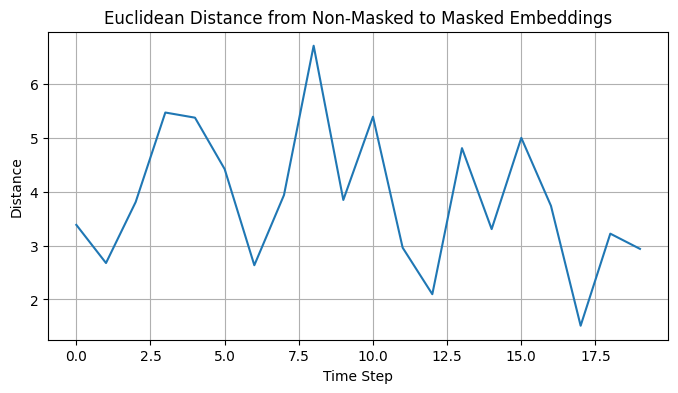

In [40]:
dist = np.linalg.norm(embeddings_x - embeddings_masked_x, axis=1)
print(dist)
plt.figure(figsize=(8, 4))
plt.plot(dist)
plt.title(f"Euclidean Distance from Non-Masked to Masked Embeddings")
plt.xlabel("Time Step")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

In [41]:
embeddings_x = embeddings_x.cpu().numpy()
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
y = y.cpu().numpy()

combined = np.vstack([embeddings_x, embeddings_masked_x])
pca = PCA(n_components=2)
combined_proj = pca.fit_transform(combined)

x_proj = combined_proj[: len(embeddings_x)]
x_prime_proj = combined_proj[len(embeddings_x) :]


df = pd.DataFrame(
    {
        "x": np.concatenate([x_proj[:, 0], x_prime_proj[:, 0]]),
        "y": np.concatenate([x_proj[:, 1], x_prime_proj[:, 1]]),
        "group": ["A"] * BATCH_SIZE + ["B"] * BATCH_SIZE,
        "point_id": list(range(BATCH_SIZE)) * 2,
    }
)

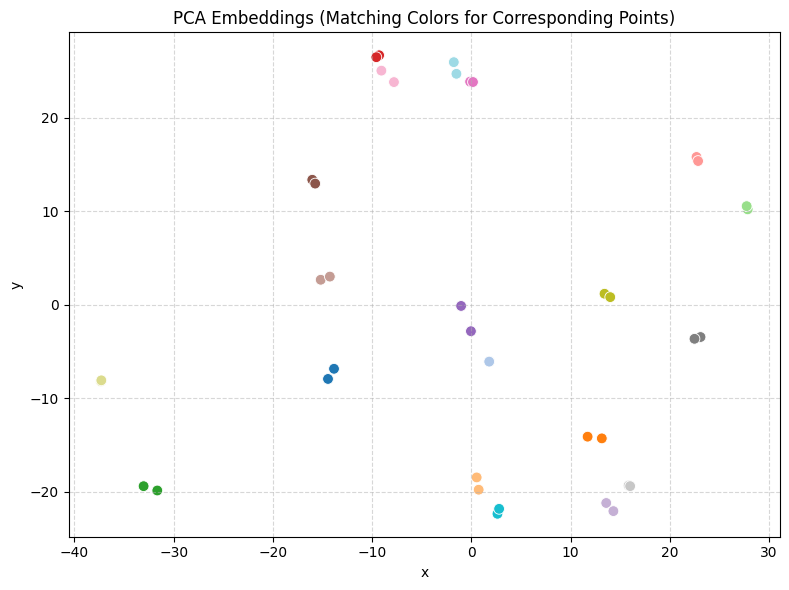

In [42]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue="point_id", palette="tab20", s=60)
plt.legend().remove()
plt.title("PCA Embeddings (Matching Colors for Corresponding Points)")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [43]:
df = pd.DataFrame(
    {"x": x_prime_proj[:, 0], "y": x_prime_proj[:, 1], "labels": y}
)

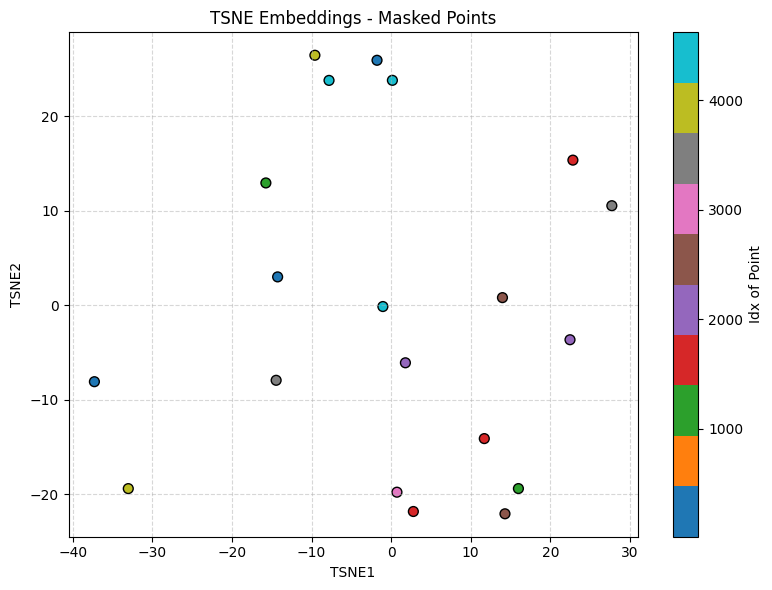

In [44]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["x"], df["y"], c=df["labels"], cmap="tab10", s=50, edgecolors="k"
)
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.title("TSNE Embeddings - Masked Points")
plt.colorbar(scatter, label="Idx of Point")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()